This notebooks tests new code in diffusers: `ControlNetXSModel`.

In [2]:
import numpy as np
import torch
from torch import tensor

Steps:
1. Load SDXL
2. Create a ControlNetXSModel instance
3. Load ControlNetXSModel weights into it
4. Run 1 denoising step

### Load our `TwoStreamControlModel`

In [2]:
device = 'cpu'
device_dtype = torch.float32

In [3]:
from diffusers.models.unet_2d_condition_control import ControlledUNet2DConditionModel

In [4]:
params = {
    'in_channels': 4,
    'out_channels': 4,
    'hint_channels': 3,
    'model_channels': 320,
    'attention_resolutions': [4, 2],
    'num_res_blocks': 2,
}

In [5]:
two_stream_model = ControlledUNet2DConditionModel(**params)

___

### Prepare the input to it

(Later, this will be done by the corresponding pipeline)

In [6]:
prompt = 'A turtle'

In [7]:
from diffusers.utils import load_image

In [8]:
try: original_image = load_image('https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png')
except Exception: original_image = load_image('/Users/umer/Desktop/input_image_vermeer.png')
image = original_image

I will need to use some preprocessing functions from `StableDiffusionControlNetPipeline`, so let create an instance

In [9]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

(We need a `StableDiffusionControlNetPipeline` instead of a regular `StableDiffusionPipeline` because it has a `prepare_image` method)

In [10]:
controlnet = ControlNetModel.from_pretrained('lllyasviel/sd-controlnet-canny', torch_dtype=device_dtype)
pipe = StableDiffusionControlNetPipeline.from_pretrained('runwayml/stable-diffusion-v1-5', controlnet=controlnet, torch_dtype=device_dtype).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [11]:
def text_enc(txt):
    tokenizer = pipe.tokenizer
    text_encoder = pipe.text_encoder

    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    return text_encoder(text_input.input_ids.to(device))[0]

In [12]:
text_embeddings = text_enc(prompt); text_embeddings.shape

torch.Size([1, 77, 768])

In [13]:
guidance_scale = 7.5
do_classifier_free_guidance = guidance_scale > 1.0

In [14]:
# 2. Define call parameters
batch_size = 1 # because prompt is a single string
num_images_per_prompt  = 1

In [15]:
prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(
    prompt,
    device,
    num_images_per_prompt,
    do_classifier_free_guidance,
)
prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
prompt_embeds.shape

torch.Size([2, 77, 768])

In [16]:
# 6. Prepare latent variables
num_channels_latents = two_stream_model.base_model.config.in_channels # we're using our unet here!
num_channels_latents

4

In [17]:
# Default values for prepare_image
height, width = None, None
generator = None
latents = None
guess_mode = False

In [18]:
# 4. Prepare image
image = pipe.prepare_image(
    image=image,
    width=width,
    height=height,
    batch_size=batch_size * num_images_per_prompt,
    num_images_per_prompt=num_images_per_prompt,
    device=device,
    dtype=controlnet.dtype,
    do_classifier_free_guidance=do_classifier_free_guidance,
    guess_mode=guess_mode,
)
height, width = image.shape[-2:]
height, width, image.shape

(512, 512, torch.Size([2, 3, 512, 512]))

In [19]:
# Default values for set_timesteps
num_inference_steps = 50

In [20]:
# 5. Prepare timesteps
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps

In [21]:
# 6. Prepare latent variables
latents = pipe.prepare_latents(
    batch_size * num_images_per_prompt,
    num_channels_latents,
    height,
    width,
    prompt_embeds.dtype,
    device,
    generator,
    latents,
)

In [22]:
latents.shape

torch.Size([1, 4, 64, 64])

In [23]:
# 8. Denoising loop
num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order

i,t = 0, timesteps[0] # NOTE: We only do 1 step for testing

In [24]:
# expand the latents if we are doing classifier free guidance
latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

In [25]:
# controlnet(s) inference
# guess_mode == False
control_model_input = latent_model_input
controlnet_prompt_embeds = prompt_embeds

In [26]:
latent_model_input.shape, t, prompt_embeds.shape

(torch.Size([2, 4, 64, 64]), tensor(981), torch.Size([2, 77, 768]))

We still need the hint

In [27]:
hint_image = original_image

In [28]:
import cv2
class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

In [29]:
def get_canny_edges(image, size=512, threshold=(50, 200)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    edges = edges / 255.
    return edges

In [30]:
import matplotlib.pyplot as plt

In [31]:
edges = get_canny_edges(hint_image)

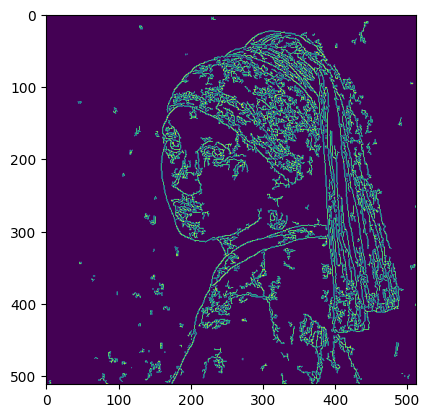

In [32]:
plt.imshow(edges);

In [33]:
num_samples=2

from einops import repeat
edges = repeat(tensor(edges), 'h w -> b c h w', b=num_samples, c=3)

In [34]:
image.shape, edges.shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 3, 512, 512]))

In [35]:
x = latent_model_input
t = t
c = {}
hint = edges.to(device, dtype=device_dtype)
no_control = False

### Run the model!

In [36]:
result = two_stream_model(x, t, prompt_embeds, c, hint)

In [37]:
result.shape

torch.Size([2, 4, 64, 64])